In [60]:
import os
import numpy as np
import pandas as pd
from numpy.linalg import svd
import matplotlib.pyplot as plt
from IPython.display import clear_output

###
import utils.dhs_config as dhs_config
import utils.dhs_utils as dhs
from utils.ot import *

### Ground Truth

In [61]:
X_batch_size = 200
X_feature_size = 50

mean1 = np.zeros(X_feature_size)
cov1 = np.diag(np.ones(X_feature_size))
mu_x = np.ones(X_batch_size)/X_batch_size
X_truth = np.random.multivariate_normal(mean1, cov1, X_batch_size)

Y_batch_size = 200
Y_feature_size = 50

mean2 = np.zeros(X_feature_size)
cov2 = np.diag(np.ones(X_feature_size))
mu_y = np.ones(Y_batch_size)/Y_batch_size
Y_truth = np.random.multivariate_normal(mean2, cov2, Y_batch_size)

In [62]:
sigma = 0.5
A_truth = np.random.normal(size=(X_feature_size, Y_feature_size))
Phi_truth = get_cost(X_truth, Y_truth, A_truth)
a_truth, b_truth = Sinkhorn(mu_x, mu_y, Phi_truth, sigma=sigma)
pi_truth = get_distr(a_truth, b_truth, Phi_truth, sigma=sigma)

## Approximation

In [63]:
A_all = {}
history_coefs_all = {}
history_grad_all = {} 
A_approx = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

for i in np.arange(2, 52, step=4):
    X = X_truth[:, :i]
    Y = Y_truth[:, :i]

    mu1 = np.ones(X_batch_size)/X_batch_size
    mu2 = np.ones(Y_batch_size)/Y_batch_size

    A = A_approx[:i, :i]

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, t=0.5, verbose=False, sigma=sigma, pi_hat=pi_truth)
    A_all[i] = A
    history_coefs_all[i] = history_coefs
    history_grad_all[i] = history_grad

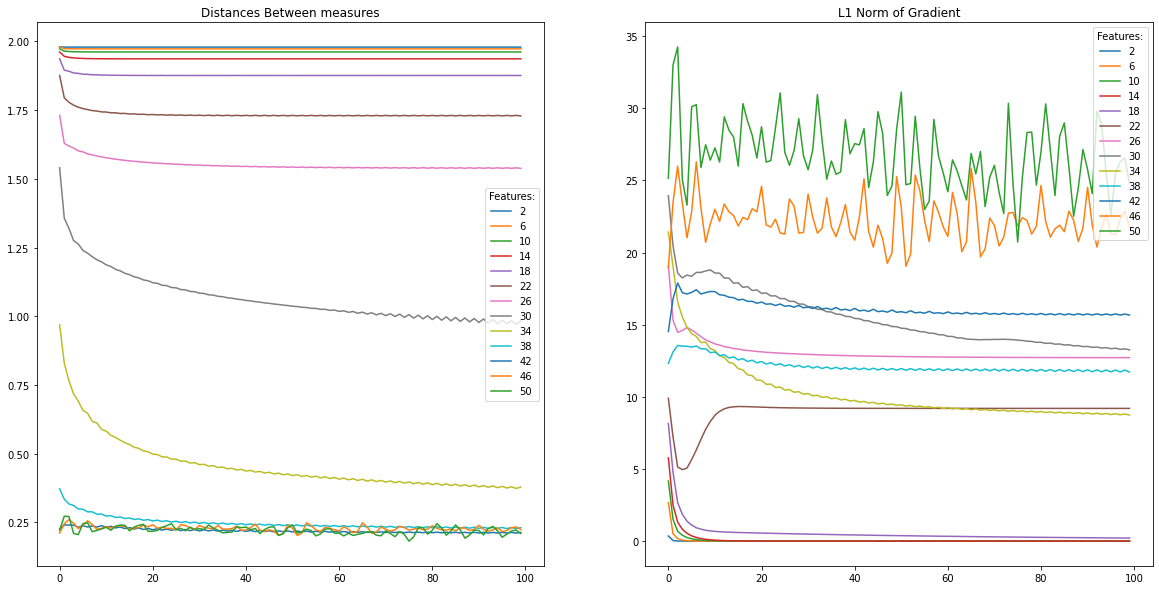

In [64]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
for key, item in history_coefs_all.items():
    ax.plot(item, label=key)
    
ax.set_title("Distances Between measures")
ax.legend(title='Features:')

ax = plt.subplot(122)

for key, item in history_grad_all.items():
    ax.plot(item, label=key)
    
ax.set_title("L1 Norm of Gradient")
ax.legend(title='Features:')

plt.show()

### Small singular values experiment

In [65]:
r = 10

sigma = 0.5
A_truth = np.random.normal(size=(X_feature_size, Y_feature_size))
U, s, V = svd(A_truth)

s_flags = np.ones_like(s)
s_flags[r:] = 0

A_small_truth = U@np.diag(s*s_flags)@V

Phi_truth = get_cost(X_truth, Y_truth, A_small_truth)
a_truth, b_truth = Sinkhorn(mu_x, mu_y, Phi_truth, sigma=sigma)
pi_truth = get_distr(a_truth, b_truth, Phi_truth, sigma=sigma)

### Approximation without svd

In [66]:
A_all = {}
history_coefs_all = {}
history_grad_all = {} 
A_approx = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

for i in np.arange(2, 52, step=4):
    X = X_truth[:, :i]
    Y = Y_truth[:, :i]

    mu1 = np.ones(X_batch_size)/X_batch_size
    mu2 = np.ones(Y_batch_size)/Y_batch_size

    A = A_approx[:i, :i]

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, t=0.5, verbose=False, sigma=sigma, pi_hat=pi_truth)
    A_all[i] = A
    history_coefs_all[i] = history_coefs
    history_grad_all[i] = history_grad

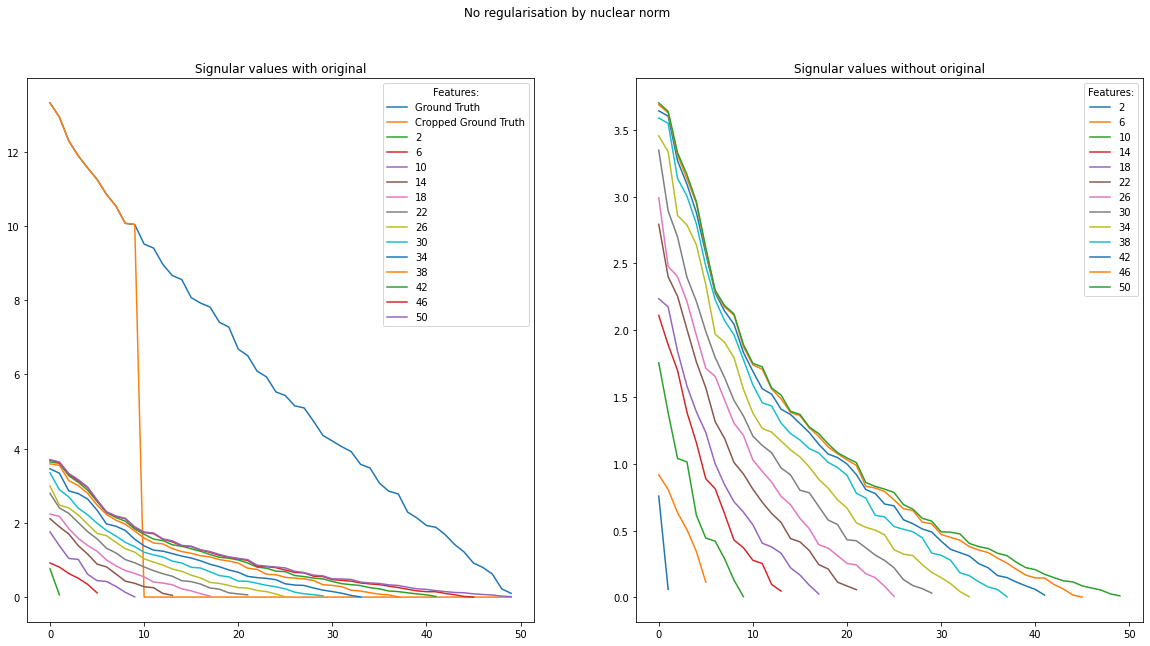

In [70]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

U, s, V = svd(A_truth)
ax1.plot(s, label="Ground Truth")

U, s, V = svd(A_small_truth)
ax1.plot(s, label="Cropped Ground Truth")

for key, item in A_all.items():
    V, s, U  = svd(item)
    ax1.plot(s, label=len(s))
    ax2.plot(s, label=len(s))
ax1.set_title("Signular values with original")
ax1.legend(title='Features:')
ax2.set_title("Signular values without original")
ax2.legend(title='Features:')

plt.suptitle("No regularisation by nuclear norm")
plt.show()

### Approximation with svd

In [86]:
A_all = {}
history_coefs_all = {}
history_grad_all = {} 
A_approx = np.random.randn(X_feature_size, Y_feature_size)/(X_feature_size*Y_feature_size)

for l in np.arange(0, 1000, step=100)/1000:
    X = X_truth
    Y = Y_truth

    mu1 = np.ones(X_batch_size)/X_batch_size
    mu2 = np.ones(Y_batch_size)/Y_batch_size

    A = A_approx

    A, history_coefs, history_grad = proximal_descent(A, X, mu1, Y, mu2, t=0.5, l=l, verbose=False, svd_flag=True, sigma=sigma, pi_hat=pi_truth)
    A_all[l] = A
    history_coefs_all[l] = history_coefs
    history_grad_all[l] = history_grad

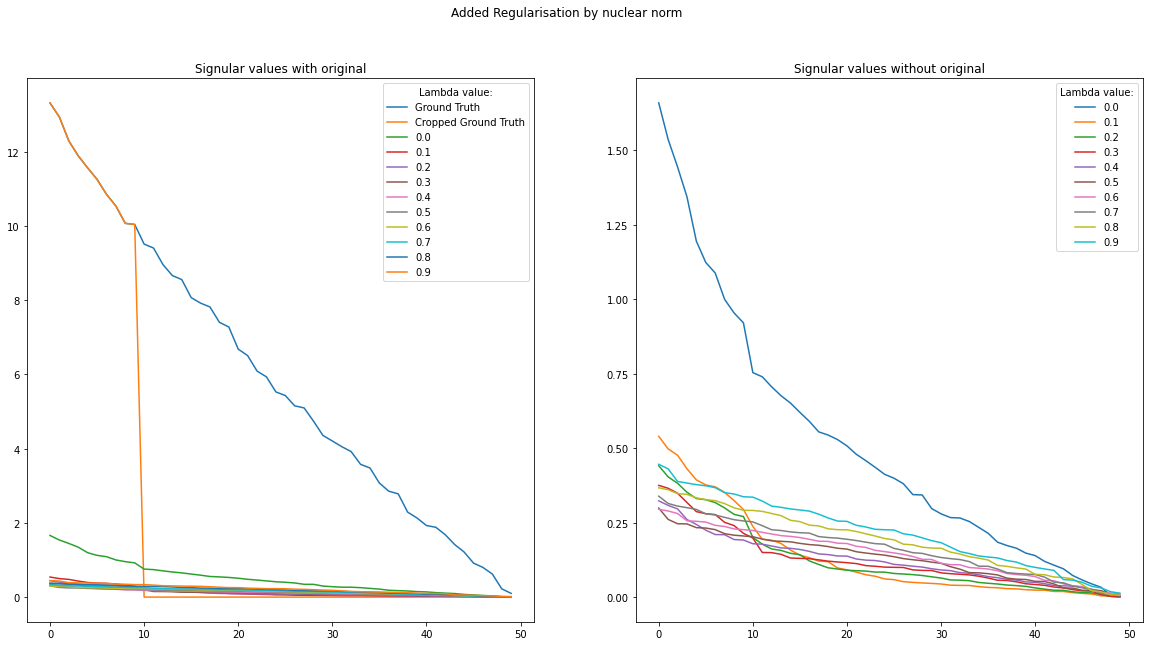

In [87]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

U, s, V = svd(A_truth)
ax1.plot(s, label="Ground Truth")

U, s, V = svd(A_small_truth)
ax1.plot(s, label="Cropped Ground Truth")

for key, item in A_all.items():
    V, s, U  = svd(item)
    ax1.plot(s, label=key)
    ax2.plot(s, label=key)
    
ax1.set_title("Signular values with original")
ax1.legend(title='Lambda value:')
ax2.set_title("Signular values without original")
ax2.legend(title='Lambda value:')

plt.suptitle("Added Regularisation by nuclear norm")
plt.show()